# A look at the distribution of the number of supporting facts per question

In [1]:
from collections import Counter
import string
import re
import argparse
import json
import sys
import numpy as np
import nltk
import random
import math
import os
import pickle
from tqdm import tqdm, trange

import pandas as pd
import seaborn as sns

import pdb

from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
cls_id = tokenizer.convert_tokens_to_ids(["[CLS]"])[0]
sep_id = tokenizer.convert_tokens_to_ids(["[SEP]"])[0]
pad_id = tokenizer.convert_tokens_to_ids(["[PAD]"])[0]
                                         

print("[CLS] : {}".format(cls_id))
print("[SEP] : {}".format(sep_id))
print("[PAD] : {}".format(pad_id))

[CLS] : 101
[SEP] : 102
[PAD] : 0


In [5]:
TRAINING = False

out_pkl_path = "./"

if(TRAINING):
    file_path = "/home/bhargav/data/hotpotqa/hotpot_train_v1.json"
    out_pkl_name = "preprocessed_train.pkl"
    small_out_pkl_name = "preprocessed_train_small.pkl"
    small_dataset_size = 5000
    problem_indices = [8437, 25197, 34122, 46031, 52955, 63867, 82250]
else:
    file_path = "/home/bhargav/data/hotpotqa/hotpot_dev_distractor_v1.json"
    out_pkl_name = "preprocessed_dev.pkl"
    small_out_pkl_name = "preprocessed_dev_small.pkl"
    small_dataset_size = 500
    problem_indices = [5059]

max_seq_len = 510
max_num_paragraphs = 10

In [6]:
with open(file_path, encoding='utf8') as file:
    dataset = json.load(file)

In [7]:
dataset[0]['supporting_facts']

[['Scott Derrickson', 0], ['Ed Wood', 0]]

In [46]:
num_supporting_facts = []
question_ids = []
supporting_facts = []
skipped = []

for item_index, item in enumerate(tqdm(dataset)):
    if(item_index in problem_indices):
        skipped.append(item_index)
        continue
    if(len(item["context"]) != 10):
        skipped.append(item_index)
        continue
    question_ids.append(item["_id"])
    num_supporting_facts.append(len(item['supporting_facts']))
    paragraph_names = []
    for i,para in enumerate(item["context"]):
        para_name = para[0]
        paragraph_names.append(para_name)
    supp_fact_list = []
    for sup_fact in item["supporting_facts"]:
        para_name = sup_fact[0]
        supporting_fact_index = sup_fact[1] 
        para_index = paragraph_names.index(para_name)
        supp_fact_list.append([para_index, supporting_fact_index])
    supporting_facts.append(supp_fact_list)

100%|██████████| 7405/7405 [00:00<00:00, 23773.19it/s]


In [47]:
supporting_facts[0]

[[1, 0], [4, 0]]

In [9]:
gold_sf_counter = Counter(num_supporting_facts)

In [10]:
gold_sf_counter

Counter({2: 4940, 3: 1767, 5: 80, 4: 533, 7: 9, 6: 14, 8: 1})

In [11]:
predicted_supporting_facts = unpickler('./','formatted_predictions.pkl')

In [12]:
type(predicted_supporting_facts)

dict

In [13]:
list(predicted_supporting_facts.keys())[:5]

['5a8b57f25542995d1e6f1371',
 '5a8c7595554299585d9e36b6',
 '5a85ea095542994775f606a8',
 '5adbf0a255429947ff17385a',
 '5a8e3ea95542995a26add48d']

In [14]:
predicted_supporting_facts['5a8b57f25542995d1e6f1371']

[[], [0], [], [], [0], [], [], [], [], []]

In [31]:
len(predicted_supporting_facts)

7344

In [15]:
def count_num_pred_sf(predicted_supporting_facts):
    out_list = []
    for q_id, sf_in_each_paragraph in predicted_supporting_facts.items():
        count = 0
        for item in sf_in_each_paragraph:
            if(len(item) > 0):
                count += 1
        out_list.append(count)
    return out_list

In [16]:
pred_num_supporting_facts = count_num_pred_sf(predicted_supporting_facts)
pred_sf_counter = Counter(pred_num_supporting_facts)

In [17]:
print("Average number of predicted supporting facts per question: ",sum(pred_num_supporting_facts)/len(pred_num_supporting_facts))
print("Average number of gold supporting facts per question: ",sum(num_supporting_facts)/len(num_supporting_facts))

Average number of predicted supporting facts per question:  2.1300381263616557
Average number of gold supporting facts per question:  2.433006535947712


In [32]:
assert(len(pred_num_supporting_facts) == len(num_supporting_facts) == len(question_ids) == len(predicted_supporting_facts))

In [40]:
assert(len((set(question_ids) - set(predicted_supporting_facts.keys()))) 
       == len((set(predicted_supporting_facts.keys()) - set(question_ids))) 
              == 0)

In [18]:
pred_sf_counter

Counter({2: 6442, 3: 828, 4: 63, 1: 8, 5: 3})

In [19]:
gold_sf_counter

Counter({2: 4940, 3: 1767, 5: 80, 4: 533, 7: 9, 6: 14, 8: 1})

In [20]:
count_dict = {'count':[] ,'gold':[], 'predicted':[]}
for i in range(1,10):
    count_dict['count'].append(i)
    count_dict['gold'].append(gold_sf_counter[i])
    count_dict['predicted'].append(pred_sf_counter[i])

In [21]:
count_dict

{'count': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'gold': [0, 4940, 1767, 533, 80, 14, 9, 1, 0],
 'predicted': [8, 6442, 828, 63, 3, 0, 0, 0, 0]}

In [22]:
sf_df = pd.DataFrame(data=count_dict)

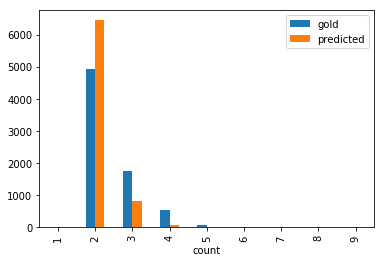

In [23]:
sf_df.plot(x="count", y=["gold", "predicted"], kind="bar")

In [41]:
gold_id_vs_num_sf = {'question_id':[], 'count':[]}
pred_id_vs_num_sf = {'question_id':[], 'count':[]}

for i in range(len(question_ids)):
    gold_id_vs_num_sf[question_ids[i]] = num_supporting_facts[i]
    pred_id_vs_num_sf[question_ids[i]] = pred_num_supporting_facts[i]

In [42]:
gold_id_vs_num_sf.keys() == pred_id_vs_num_sf.keys()

True

In [43]:
sf_counts_pred_and_gold = {'gold': gold_id_vs_num_sf, 'pred': pred_id_vs_num_sf}

In [45]:
pickler('./','sf_counts_pred_and_gold.pkl', sf_counts_pred_and_gold)